In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

import pickle as pkl
import pandas as pd
import os
import requests as r
from sklearn.metrics import accuracy_score
import random

np.random.seed(37)

random.seed(1254)

tf.random.set_seed(89)

tf.executing_eagerly()


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

stages = ['CE', 'SCL']

dataset = 'UTKFace'
net = 'R50'
version = 'V1'

stage = stages[0]

script_name_template = '{}-{}-{}-BatchNorm-MultiOutput-AutoAug-224-{}'
script_name = script_name_template.format(version, dataset, net, stage)

In [2]:
if net == 'R50':
    from tensorflow.keras.applications.resnet_v2 import preprocess_input
    from tensorflow.keras.applications import ResNet50V2 as backbone_net
if net == 'Mnet':
    from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
    from tensorflow.keras.applications import MobileNetV2 as backbone_net

In [3]:
def encode(data, mask):
    labels = []
    for item in data:
        labels.append(mask[item])
    return labels

In [4]:
csv_target_train = '{}/train.csv'.format(dataset)
directory_data = dataset
df_train = pd.read_csv(csv_target_train)

if dataset == 'FairFace':
    csv_target_val = '{}/val.csv'.format(dataset)
    df_val = pd.read_csv(csv_target_val)

if dataset == 'AFAD-Full':
    bins = [0, 3, 10, 20, 30, 40, 50, 60, 70, np.inf]
    names = ['0-2', '3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']
    df_train['age'] = pd.cut(df_train['age_abs'], bins, labels=names)

if dataset == 'UTKFace':
    directory_data = './'
    
df_train

,gender,race,file,age
0,Male,Asian,UTKFace/images/5_0_2_20161219192745531.jpg.chi...,3-9
1,Female,White,UTKFace/images/60_1_0_20170110122614299.jpg.ch...,50-59
2,Male,Black,UTKFace/images/3_0_1_20170119145547519.jpg.chi...,0-2
3,Male,Black,UTKFace/images/26_0_1_20170117172711486.jpg.ch...,20-29
4,Female,White,UTKFace/images/24_1_0_20170117145637012.jpg.ch...,20-29
...,...,...,...,...
23700,Female,Black,UTKFace/images/46_1_1_20170113012755554.jpg.ch...,40-49
23701,Female,Asian,UTKFace/images/24_1_2_20170116171604159.jpg.ch...,20-29
23702,Male,White,UTKFace/images/40_0_0_20170117185304858.jpg.ch...,30-39
23703,Female,Black,UTKFace/images/31_1_1_20170116224134208.jpg.ch...,30-39


In [5]:
def label2dict(df):
    values = df.unique()
    d = {}
    for idx, v in enumerate(values):
        d[v] = idx
    return d
def apply_encode(map_dict, col, row):
    return map_dict[row[col]]

In [6]:
target_col = ['gender', 'race', 'age']
if dataset == 'AFAD-Full':
    target_col = ['gender', 'age']
num_classes = []
for col in target_col:
    num_classes.append(df_train[col].nunique())
input_shape = (224, 224, 3)
batch_size = 64
learning_rate = 0.001
hidden_units = 512
projection_units = 128
num_epochs = 50
dropout_rate = 0.5
temperature = 0.1
validation_split = 0.1

In [7]:
target_col_data = []
for col in target_col:
    col2 = col + '_sparse'
    target_col_data.append(col2)
    map_dict = label2dict(df_train[col])
    df_train[col2] = df_train.apply(lambda row: apply_encode(map_dict, col, row), axis=1)
    if dataset == 'FairFace':
        df_val[col2] = df_val.apply(lambda row: apply_encode(map_dict, col, row), axis=1)

In [8]:
x_col = 'file'
y_col = target_col_data
train_generator = keras.preprocessing.image.ImageDataGenerator(
    validation_split=validation_split
)
val_generator = keras.preprocessing.image.ImageDataGenerator(
)


if dataset == 'FairFace':
    train_iter = train_generator.flow_from_dataframe(
        df_train,
        directory=directory_data,
        x_col=x_col,
        y_col=y_col,
        class_mode="multi_output",
        target_size=(input_shape[0], input_shape[1]),
        batch_size=batch_size,
    )

    val_iter = val_generator.flow_from_dataframe(
        df_val,
        directory=directory_data,
        x_col=x_col,
        y_col=y_col,
        class_mode="multi_output",
        target_size=(input_shape[0], input_shape[1]),
        batch_size=batch_size,
        shuffle=False,
    )
else:
    train_iter = train_generator.flow_from_dataframe(
        df_train,
        directory=directory_data,
        x_col=x_col,
        y_col=y_col,
        class_mode="multi_output",
        target_size=(input_shape[0], input_shape[1]),
        batch_size=batch_size,
        subset='training'
    )

    val_iter = train_generator.flow_from_dataframe(
        df_train,
        directory=directory_data,
        x_col=x_col,
        y_col=y_col,
        class_mode="multi_output",
        target_size=(input_shape[0], input_shape[1]),
        batch_size=batch_size,
        subset='validation'
    )

Found 21335 validated image filenames.
Found 2370 validated image filenames.


In [9]:
callbacks = []
if len(target_col) == 1:
    for col in target_col:
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath='./ckpt/{}-{}.h5'.format(script_name, col),
            monitor='val_sparse_categorical_accuracy'.format(col),
            mode='max',
            save_best_only=True)
        callbacks.append(model_checkpoint_callback)
else:
    for col in target_col:
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath='./ckpt/{}-{}.h5'.format(script_name, col),
            monitor='val_{}_sparse_categorical_accuracy'.format(col),
            mode='max',
            save_best_only=True)
        callbacks.append(model_checkpoint_callback)

In [10]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.02),
        layers.experimental.preprocessing.RandomWidth(0.2),
        layers.experimental.preprocessing.RandomHeight(0.2),
        layers.experimental.preprocessing.RandomTranslation((-0.2, 0.2), (-0.2, 0.2)),
        layers.experimental.preprocessing.RandomContrast((0.1, 0.2))
        
    ]
)
def create_encoder():
    resnet = keras.applications.ResNet50V2(
        include_top=False, weights=None, input_shape=input_shape, pooling="avg"
    )

    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    x = layers.experimental.preprocessing.Rescaling(scale=1./127.5, offset=-1)(augmented)
    outputs = resnet(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name="encoder")
    return model

In [11]:
def create_classifier(encoder, trainable=True, training=True):
    
    encoder.trainable = trainable

    inputs = keras.Input(shape=input_shape, name="input")
    features = encoder(inputs, training=training)
    outputs = []
    for idx, num_class in enumerate(num_classes):
        _features = layers.Dropout(dropout_rate, name="dropout_" + target_col[idx])(features)
        _features = layers.Dense(hidden_units, activation="relu", name = "features_"+ target_col[idx])(_features)
        _features = layers.Dropout(dropout_rate, name="dropout2_" + target_col[idx])(_features)
        outputs.append(layers.Dense(num_class, activation="softmax", name=target_col[idx])(_features))

    model = keras.Model(inputs=inputs, outputs=outputs, name="classifier")
    metrics = {}
    loss = []
    loss_weights = []
    for col in target_col:
        metrics[col] = keras.metrics.SparseCategoricalAccuracy()
        loss.append(keras.losses.SparseCategoricalCrossentropy())
        loss_weights.append(0.1)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=loss,
        metrics=metrics,
        loss_weights=loss_weights
    )
    return model

In [12]:
encoder = create_encoder()
encoder.summary()
classifier = create_classifier(encoder)
classifier.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
rescaling (Rescaling)        (None, None, None, 3)     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 2048)              23564800  
Total params: 23,564,800
Trainable params: 23,519,360
Non-trainable params: 45,440
_________________________________________________________________
Model: "classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)    

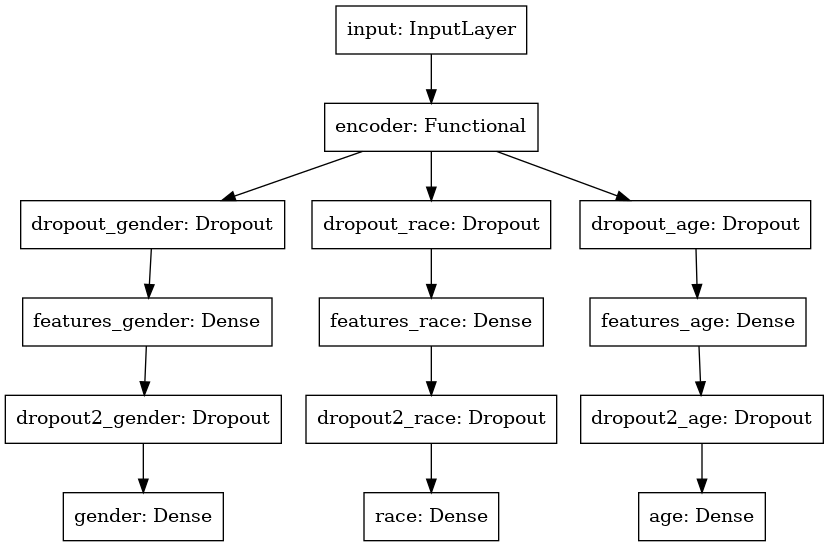

In [13]:
keras.utils.plot_model(classifier)

In [14]:
history = classifier.fit(train_iter, batch_size=batch_size, epochs=num_epochs, validation_data=val_iter, callbacks=callbacks)

classifier.save('./ckpt/{}-{}.h5'.format(script_name, 'last'))

Epoch 1/50
334/334 [==============================] - 198s 568ms/step - loss: 0.3981 - gender_loss: 0.6648 - race_loss: 1.4097 - age_loss: 1.9062 - gender_sparse_categorical_accuracy: 0.6386 - race_sparse_categorical_accuracy: 0.4605 - age_sparse_categorical_accuracy: 0.3416 - val_loss: 0.3644 - val_gender_loss: 0.6017 - val_race_loss: 1.2932 - val_age_loss: 1.7490 - val_gender_sparse_categorical_accuracy: 0.6814 - val_race_sparse_categorical_accuracy: 0.5004 - val_age_sparse_categorical_accuracy: 0.3781


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
334/334 [==============================] - 109s 328ms/step - loss: 0.3492 - gender_loss: 0.5410 - race_loss: 1.2829 - age_loss: 1.6676 - gender_sparse_categorical_accuracy: 0.7334 - race_sparse_categorical_accuracy: 0.4965 - age_sparse_categorical_accuracy: 0.3900 - val_loss: 0.3161 - val_gender_loss: 0.4734 - val_race_loss: 1.1555 - val_age_loss: 1.5322 - val_gender_sparse_categorical_accuracy: 0.7819 - val_race_sparse_categorical_accuracy: 0.5612 - val_age_sparse_categorical_accuracy: 0.4380
Epoch 3/50
334/334 [==============================] - 90s 268ms/step - loss: 0.3112 - gender_loss: 0.4488 - race_loss: 1.1300 - age_loss: 1.5333 - gender_sparse_categorical_accuracy: 0.7900 - race_sparse_categorical_accuracy: 0.5742 - age_sparse_categorical_accuracy: 0.4238 - val_loss: 0.2885 - val_gender_loss: 0.4077 - val_race_loss: 1.0247 - val_age_loss: 1.4530 - val_gender_sparse_categorical_accuracy: 0.8084 - val_race_sparse_categorical_accuracy: 0.6101 - val_age_sparse_categorica

In [15]:
stage = stages[1]
script_name = script_name_template.format(version, dataset, net, stage)

In [16]:
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)


def add_projection_head(encoder):
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = []
    for col in target_col:
        outputs.append(layers.Dense(projection_units, activation="relu", name="features_" + col)(features))
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="encoder_with_projection-head"
    )
    return model

Model: "encoder_with_projection-head"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
encoder (Functional)            (None, 2048)         23564800    input_5[0][0]                    
__________________________________________________________________________________________________
features_gender (Dense)         (None, 128)          262272      encoder[0][0]                    
__________________________________________________________________________________________________
features_race (Dense)           (None, 128)          262272      encoder[0][0]                    
_______________________________________________________________________

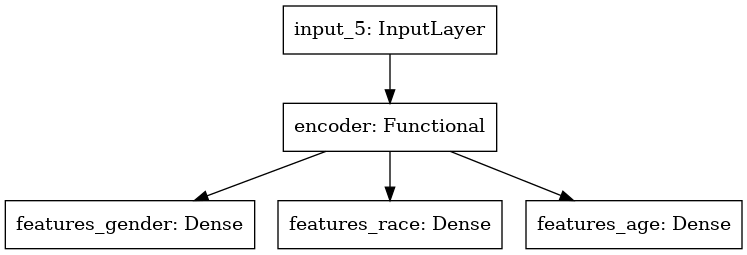

In [17]:
encoder = create_encoder()
loss = []
loss_weights = []
for col in target_col:
    loss.append(SupervisedContrastiveLoss(temperature))
    loss_weights.append(0.1)
encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=loss,
    loss_weights=loss_weights
)

encoder_with_projection_head.summary()
keras.utils.plot_model(encoder_with_projection_head)

In [18]:
history = encoder_with_projection_head.fit(
    train_iter, batch_size=batch_size, epochs=num_epochs
)


Epoch 1/50
334/334 [==============================] - 61s 167ms/step - loss: 1.2340 - features_gender_loss: 4.1532 - features_race_loss: 4.1225 - features_age_loss: 4.0639
Epoch 2/50
334/334 [==============================] - 56s 167ms/step - loss: 1.2127 - features_gender_loss: 4.1186 - features_race_loss: 4.0921 - features_age_loss: 3.9161
Epoch 3/50
334/334 [==============================] - 56s 167ms/step - loss: 1.1912 - features_gender_loss: 4.0641 - features_race_loss: 4.0345 - features_age_loss: 3.8132
Epoch 4/50
334/334 [==============================] - 56s 167ms/step - loss: 1.1742 - features_gender_loss: 4.0212 - features_race_loss: 3.9725 - features_age_loss: 3.7486
Epoch 5/50
334/334 [==============================] - 56s 167ms/step - loss: 1.1585 - features_gender_loss: 3.9851 - features_race_loss: 3.9055 - features_age_loss: 3.6943
Epoch 6/50
334/334 [==============================] - 56s 167ms/step - loss: 1.1451 - features_gender_loss: 3.9583 - features_race_loss: 3.8

<Response [200]>

In [19]:
callbacks = []
if len(target_col) == 1:
    for col in target_col:
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath='./ckpt/{}-{}.h5'.format(script_name, col),
            monitor='val_sparse_categorical_accuracy'.format(col),
            mode='max',
            save_best_only=True)
        callbacks.append(model_checkpoint_callback)
else:
    for col in target_col:
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath='./ckpt/{}-{}.h5'.format(script_name, col),
            monitor='val_{}_sparse_categorical_accuracy'.format(col),
            mode='max',
            save_best_only=True)
        callbacks.append(model_checkpoint_callback)

In [20]:
classifier = create_classifier(encoder, trainable=False, training=False)
history = classifier.fit(train_iter, batch_size=batch_size, epochs=10, validation_data=val_iter, callbacks=callbacks)

Epoch 1/10
334/334 [==============================] - 44s 125ms/step - loss: 0.1599 - gender_loss: 0.1602 - race_loss: 0.4324 - age_loss: 1.0060 - gender_sparse_categorical_accuracy: 0.9422 - race_sparse_categorical_accuracy: 0.8629 - age_sparse_categorical_accuracy: 0.5955 - val_loss: 0.1604 - val_gender_loss: 0.1831 - val_race_loss: 0.4882 - val_age_loss: 0.9324 - val_gender_sparse_categorical_accuracy: 0.9350 - val_race_sparse_categorical_accuracy: 0.8388 - val_age_sparse_categorical_accuracy: 0.6135


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
334/334 [==============================] - 41s 123ms/step - loss: 0.1402 - gender_loss: 0.1354 - race_loss: 0.3771 - age_loss: 0.8899 - gender_sparse_categorical_accuracy: 0.9527 - race_sparse_categorical_accuracy: 0.8802 - age_sparse_categorical_accuracy: 0.6285 - val_loss: 0.1583 - val_gender_loss: 0.1808 - val_race_loss: 0.4732 - val_age_loss: 0.9286 - val_gender_sparse_categorical_accuracy: 0.9405 - val_race_sparse_categorical_accuracy: 0.8435 - val_age_sparse_categorical_accuracy: 0.6245
Epoch 3/10
334/334 [==============================] - 41s 123ms/step - loss: 0.1381 - gender_loss: 0.1317 - race_loss: 0.3671 - age_loss: 0.8821 - gender_sparse_categorical_accuracy: 0.9533 - race_sparse_categorical_accuracy: 0.8831 - age_sparse_categorical_accuracy: 0.6309 - val_loss: 0.1594 - val_gender_loss: 0.1688 - val_race_loss: 0.4984 - val_age_loss: 0.9264 - val_gender_sparse_categorical_accuracy: 0.9388 - val_race_sparse_categorical_accuracy: 0.8435 - val_age_sparse_categorical

<Response [200]>

In [21]:
classifier.trainable = True
classifier.summary()
history = classifier.fit(train_iter, batch_size=batch_size, epochs=num_epochs, initial_epoch=10, validation_data=val_iter, callbacks=callbacks)
classifier.save('./ckpt/{}-{}.h5'.format(script_name, 'last'))

Model: "classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
encoder (Functional)            (None, 2048)         23564800    input[0][0]                      
__________________________________________________________________________________________________
dropout_gender (Dropout)        (None, 2048)         0           encoder[1][0]                    
__________________________________________________________________________________________________
dropout_race (Dropout)          (None, 2048)         0           encoder[1][0]                    
_________________________________________________________________________________________

In [22]:
res = []
names = []
for stage in stages:
    names.append(script_name_template.format(version, dataset, net, stage) + '-{}.h5')
for name in names:
    for col in target_col + ['last']:
        model_file = 'ckpt/' + name.format(col)
        model = keras.models.load_model(model_file)
        eval_res = model.evaluate(val_iter)
        eval_res = [name.format(col)] + eval_res
        res.append(eval_res)
columns = ['name', 'total_loss']
if len(target_col) == 1:
    columns.append('acc')
else:
    for m in ['loss', 'acc']:
        for col in target_col:
            columns.append('{}_{}'.format(col, m))
df_res = pd.DataFrame(res, columns = columns)
df_res.to_csv('Compare - Scratch - SupCon - {} - {}.csv'.format(version, dataset))

38/38 [==============================] - 5s 107ms/step - loss: 0.1627 - gender_loss: 0.1789 - race_loss: 0.5048 - age_loss: 0.9431 - gender_sparse_categorical_accuracy: 0.9401 - race_sparse_categorical_accuracy: 0.8426 - age_sparse_categorical_accuracy: 0.6224
